In [1]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from all_functions import *
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from aeon.transformations.detrend import STLTransformer
import ast
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error, make_scorer
import os
warnings.filterwarnings("ignore")
%matplotlib inline
def convert_to_list(series_str):
    return eval(series_str)


In [2]:
transformations = ["normal", "deseasonal", "log"]
models = ["knn", "rf", 'svr', 'catboost']
# models = [
#            "knn_noresid",
#            "rf_noresid",
#            "svr_noresid"
#            ]
noResid = True
test_date = '2023-03_2024-02'
results_file = f'./combination/all/{test_date}'
horizon = 12
window = 12
expected_sequence = [
    '2023-03_2024-02',
    '2022-03_2023-02',
    '2021-03_2022-02',
    '2020-03_2021-02',
    '2019-03_2020-02',
    '2018-03_2019-02',
    '2017-03_2018-02',
    '2016-03_2017-02',
    '2015-03_2016-02',
    '2014-03_2015-02',
    '2013-03_2014-02',
    '2012-03_2013-02',
    '2011-03_2012-02',
    '2010-03_2011-02',
    '2009-03_2010-02',
    '2008-03_2009-02',
    '2007-03_2008-02',
    '2006-03_2007-02',
    '2005-03_2006-02',
    '2004-03_2005-02',
    '2003-03_2004-02',
    '2002-03_2003-02',
    '2001-03_2002-02',
    '2000-03_2001-02',
    '1999-03_2000-02',
    '1998-03_1999-02',
    '1997-03_1998-02',
    '1996-03_1997-02',
    '1995-03_1996-02',
    '1994-03_1995-02',
    '1993-03_1994-02'
]
dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    '../datasets/venda/mensal/uf/etanolhidratado/',
    '../datasets/venda/mensal/uf/glp/',
    '../datasets/venda/mensal/uf/oleodiesel/',
    # '../datasets/venda/mensal/uf/querosenedeaviacao/',
]
colunas = ['DATA', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE', 'MASE',
           'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12',
           ]
for directory in dirs:
    for file in os.listdir(directory) :
        if file.endswith('.csv'):
            uf = file.split("_")[1].upper()
            derivado = file.split("_")[2].split(".")[0]
            full_path = os.path.join(directory, file)
            series = read_series(full_path)
            _, test = train_test_stats(series, horizon)

            predictions = {}
            preds_elastic = []
            preds_barycenter = []
            
            for model in models:
                for transform in transformations:
                    df = pd.read_csv(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', sep=";")
                    present_sequences = set(df['test_range'])

                    expected_set = set(expected_sequence)

                    missing_sequences = expected_set - present_sequences
                    if len(missing_sequences) > 0:
                        print(f"Falta em {model}/{derivado}/{transform}/transform_{uf}.csv:")
                        for seq in sorted(missing_sequences):
                            print(seq)

Falta em knn/etanolhidratado/log/transform_RR.csv:
2004-03_2005-02
Falta em rf/etanolhidratado/log/transform_RR.csv:
2004-03_2005-02
Falta em svr/etanolhidratado/log/transform_RR.csv:
2004-03_2005-02
Falta em catboost/etanolhidratado/log/transform_RR.csv:
2004-03_2005-02


In [5]:
def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results

def get_params_model(caminho_arquivo, test_date):
    df = pd.read_csv(caminho_arquivo, sep=';')
    
    df_filtrado = df[df['test_range'] == test_date]
    params_dict = ast.literal_eval(df_filtrado['PARAMS'].iloc[0])
    
    return params_dict

def generate_index(start_date, end_date):
    end_date_dt = pd.to_datetime(end_date)
    
    start_date_dt = pd.to_datetime(start_date)
    
    index = pd.period_range(start=start_date_dt, end=end_date_dt, freq='M')

    return index

def get_metric(caminho_arquivo, test_date, metric):
    df = pd.read_csv(caminho_arquivo, sep=';')
    
    df_filtrado = df[df['test_range'] == test_date]
    valor = df_filtrado[metric].iloc[0]
    
    return valor

In [6]:
window = 12
horizon = 12
derivado = "gasolinac"
estado = "SP"
modelo = "arima"
format = "deseasonal"
test_date = "2023-03_2024-02"
start_date, end_date = test_date.split('_')
test_index = generate_index(start_date, end_date)

arquivo = f'./results_hybrid/{modelo}/{derivado}/{format}/transform_{estado}.csv'
params = get_params_model(arquivo, test_date)
preds = get_preds_hybrid(arquivo, test_date, test_index)
mape = get_metric(arquivo, test_date, 'MAPE')
pbe = get_metric(arquivo, test_date, 'PBE')
pocid = get_metric(arquivo, test_date, 'POCID')


In [7]:
run_id = log_mlflow_run(
    experiment_name='gasolinac',
    state="SP",
    obs_value='ARIMA sem sazonalidade na hora de treinar',
    model_name='ARIMA',
    dict_infos={
        'params': params,
        'metrics': {'PBE': pbe, 'POCID': pocid, 'MAPE': mape}
    }
)

print(f"Logged KNN run with ID: {run_id}")

Logged KNN run with ID: f04bacbe4f324d43b977f133b0d5d88a


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

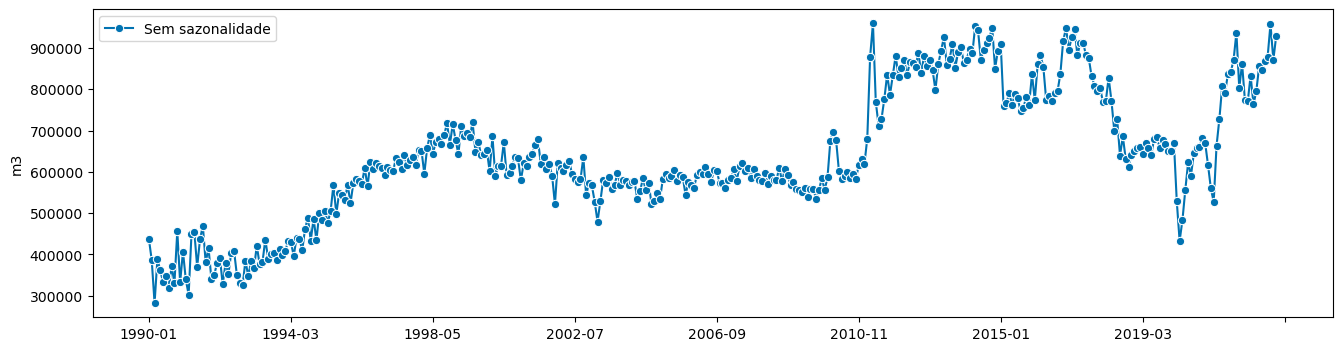

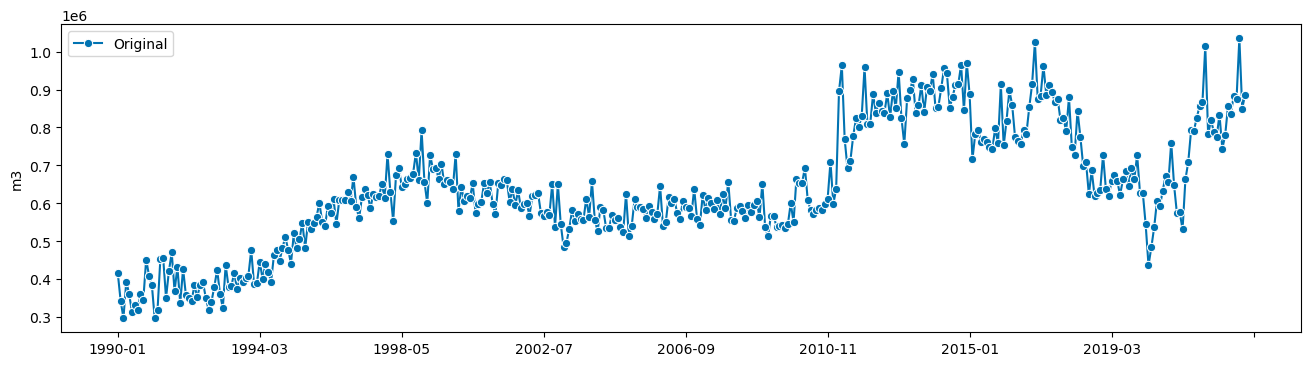

In [8]:
window = 12
horizon = 12
derivado = "gasolinac"
estado = "SP"

s = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')

train, test = train_test_stats(s, horizon)
train_tf = transform_train(train, format="deseasonal")

transform = ConditionalDeseasonalizer(sp=12)
transform.fit(train)
series_ts = transform.transform(train)
# plot_series(series_ts, train, labels=["Sem sazonalidade", "original"])
plot_series(series_ts, labels=["Sem sazonalidade"])
plot_series(train, labels=["Original"])